In [1]:
import os
from os import environ as ENV
ENV['CUDA_VISIBLE_DEVICES'] = '1'
ROOT = ENV['PWD']

from time import time as now
from itertools import combinations
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import scipy
from scipy.special import expit as sigmoid

import jax
import jax.numpy as jnp

import numpy as np
import numpy.typing as npt

Float = np.float64

print(jax.devices())
jax.config.update("jax_enable_x64", True)

import pennylane as qml
dev_gpu = qml.device("lightning.qubit", wires=18)  # GPU not that much slower, helps with indexing ig?
dev_cpu = qml.device("lightning.qubit", wires=4)  # CPU faster for 4 qubits

[cuda(id=0)]


In [2]:
dev_cpu, dev_gpu

(<lightning.qubit device (wires=4) at 0x7f88b411bc90>,
 <lightning.qubit device (wires=18) at 0x7f87cabbf450>)

In [3]:
# pennylane-catalyst uv/venv metagarbage
import catalyst
# https://github.com/PennyLaneAI/catalyst/pull/1839
# catalyst.utils.runtime_environment.get_cli_path = lambda: ENV['PWD'] + '/.venv/bin/catalyst'
catalyst.utils.runtime_environment.get_cli_path()

'/home/user/work/quadrigems/.venv/bin/catalyst'

In [4]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

In [5]:
circuit_ang      = executor(dev_gpu)(circuit_angle_swap )
circuit_ang_qft      = executor(dev_gpu)(circuit_angle_qft_swap )
circuit_amp      = executor(dev_cpu)(circuit_amp_iamp       )
circuit_amp_qft  = executor(dev_cpu)(circuit_amp_iamp_qft   )


In [6]:
# test input for angle embedding
a = np.array(list(range(9)), dtype=Float)

# test input for amplitude embedding
b = np.array(list(range(16)), dtype=Float)

# Circuit figures

(<Figure size 1400x1900 with 1 Axes>, <Axes: >)

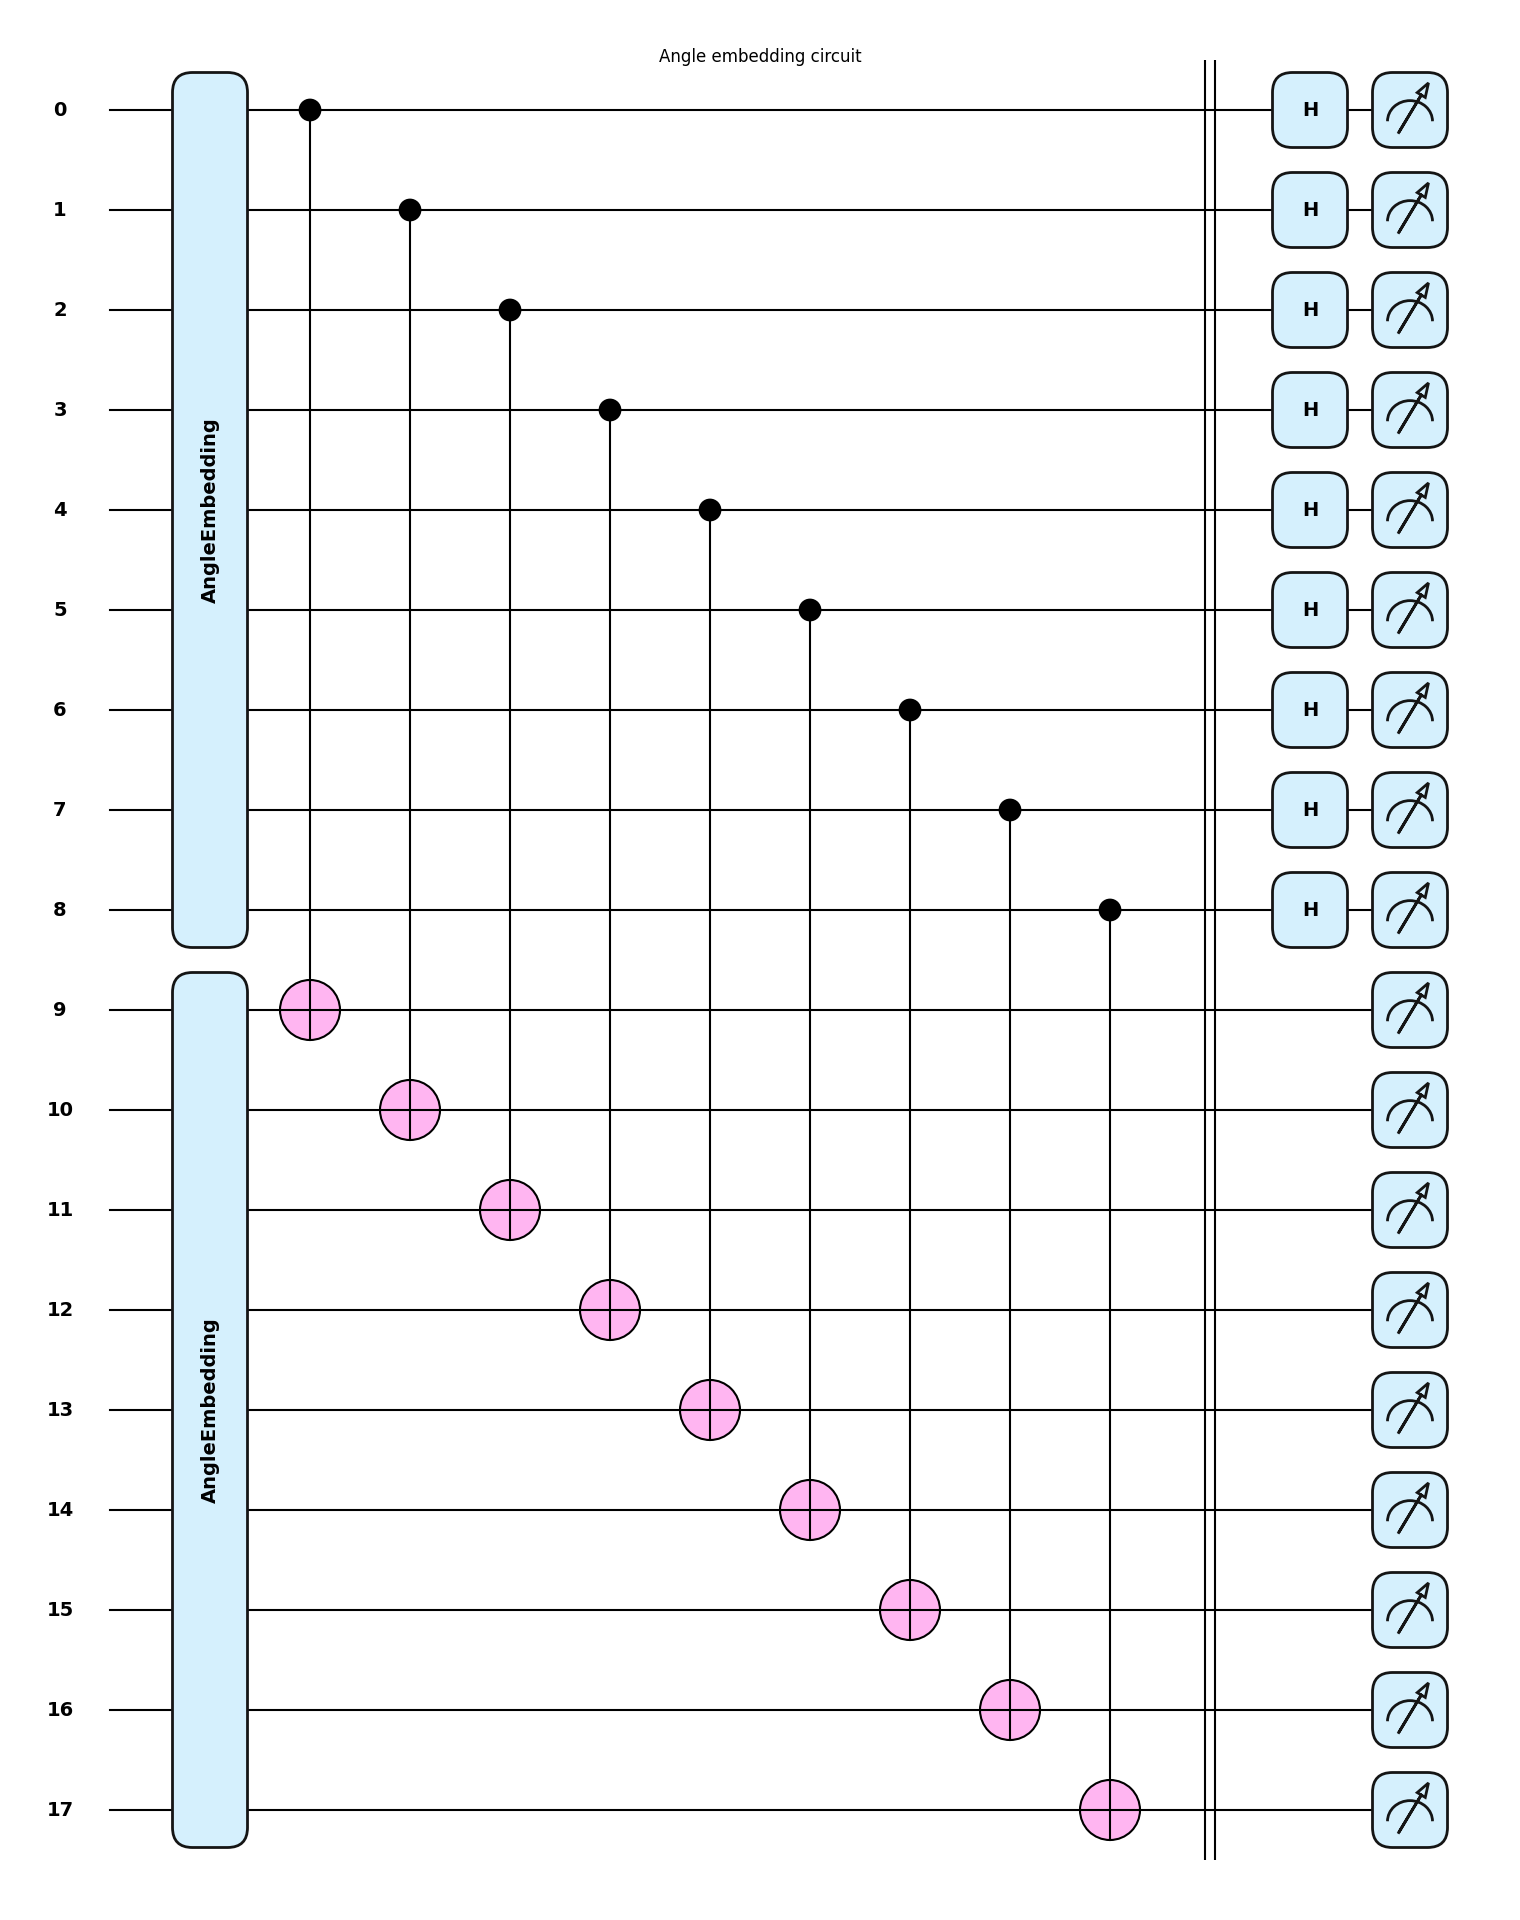

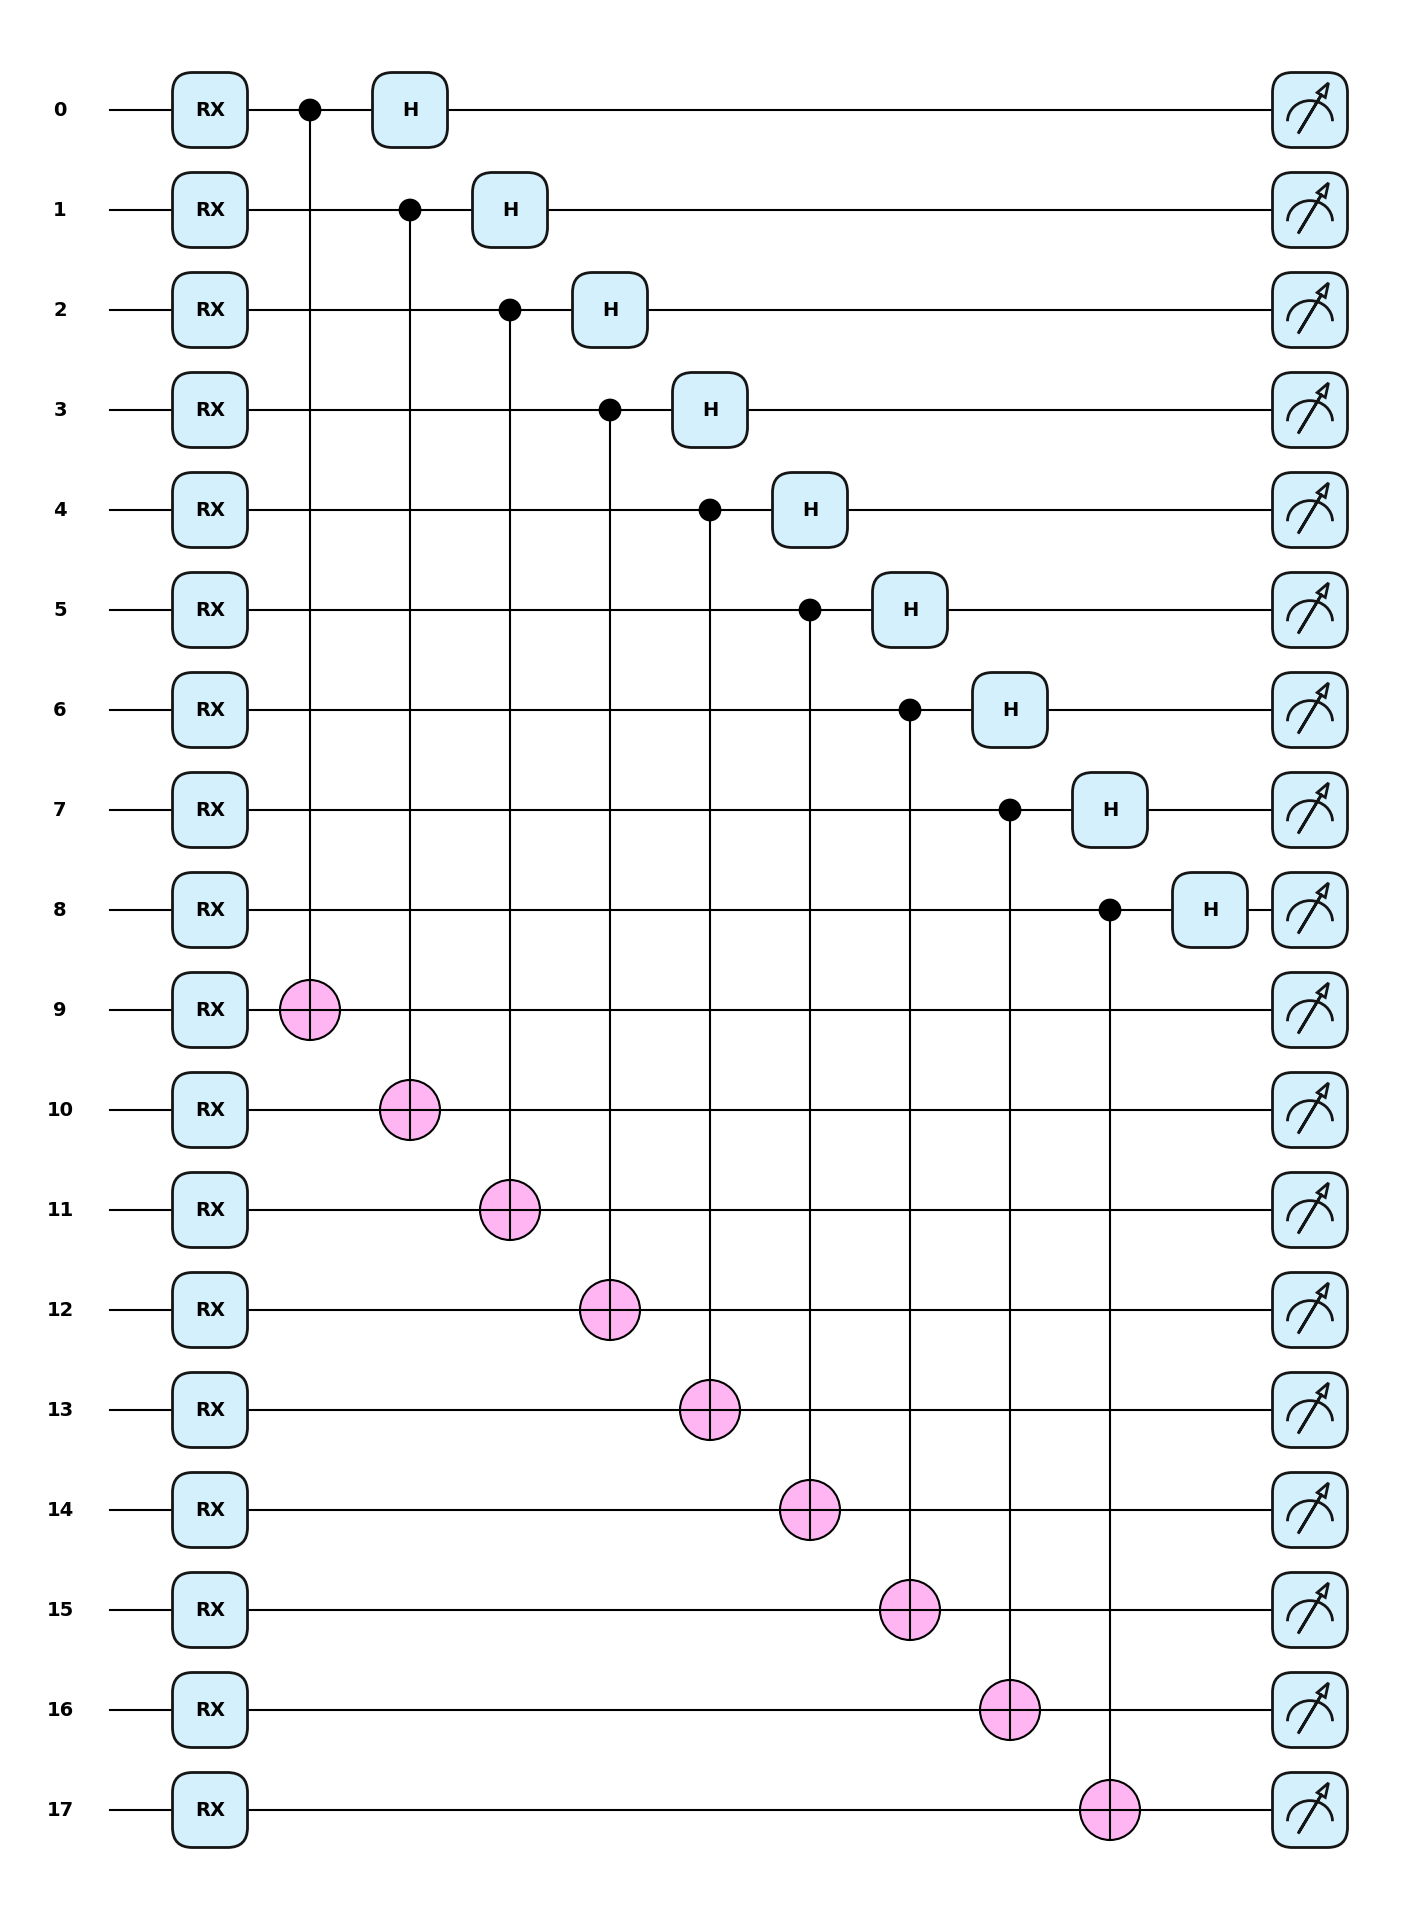

In [7]:
qml.draw_mpl(circuit_ang, level='user', style='pennylane')(a, a)
plt.suptitle('Angle embedding circuit')
qml.draw_mpl(circuit_ang, level='device', style='pennylane')(a, a)

(<Figure size 6300x1900 with 1 Axes>, <Axes: >)

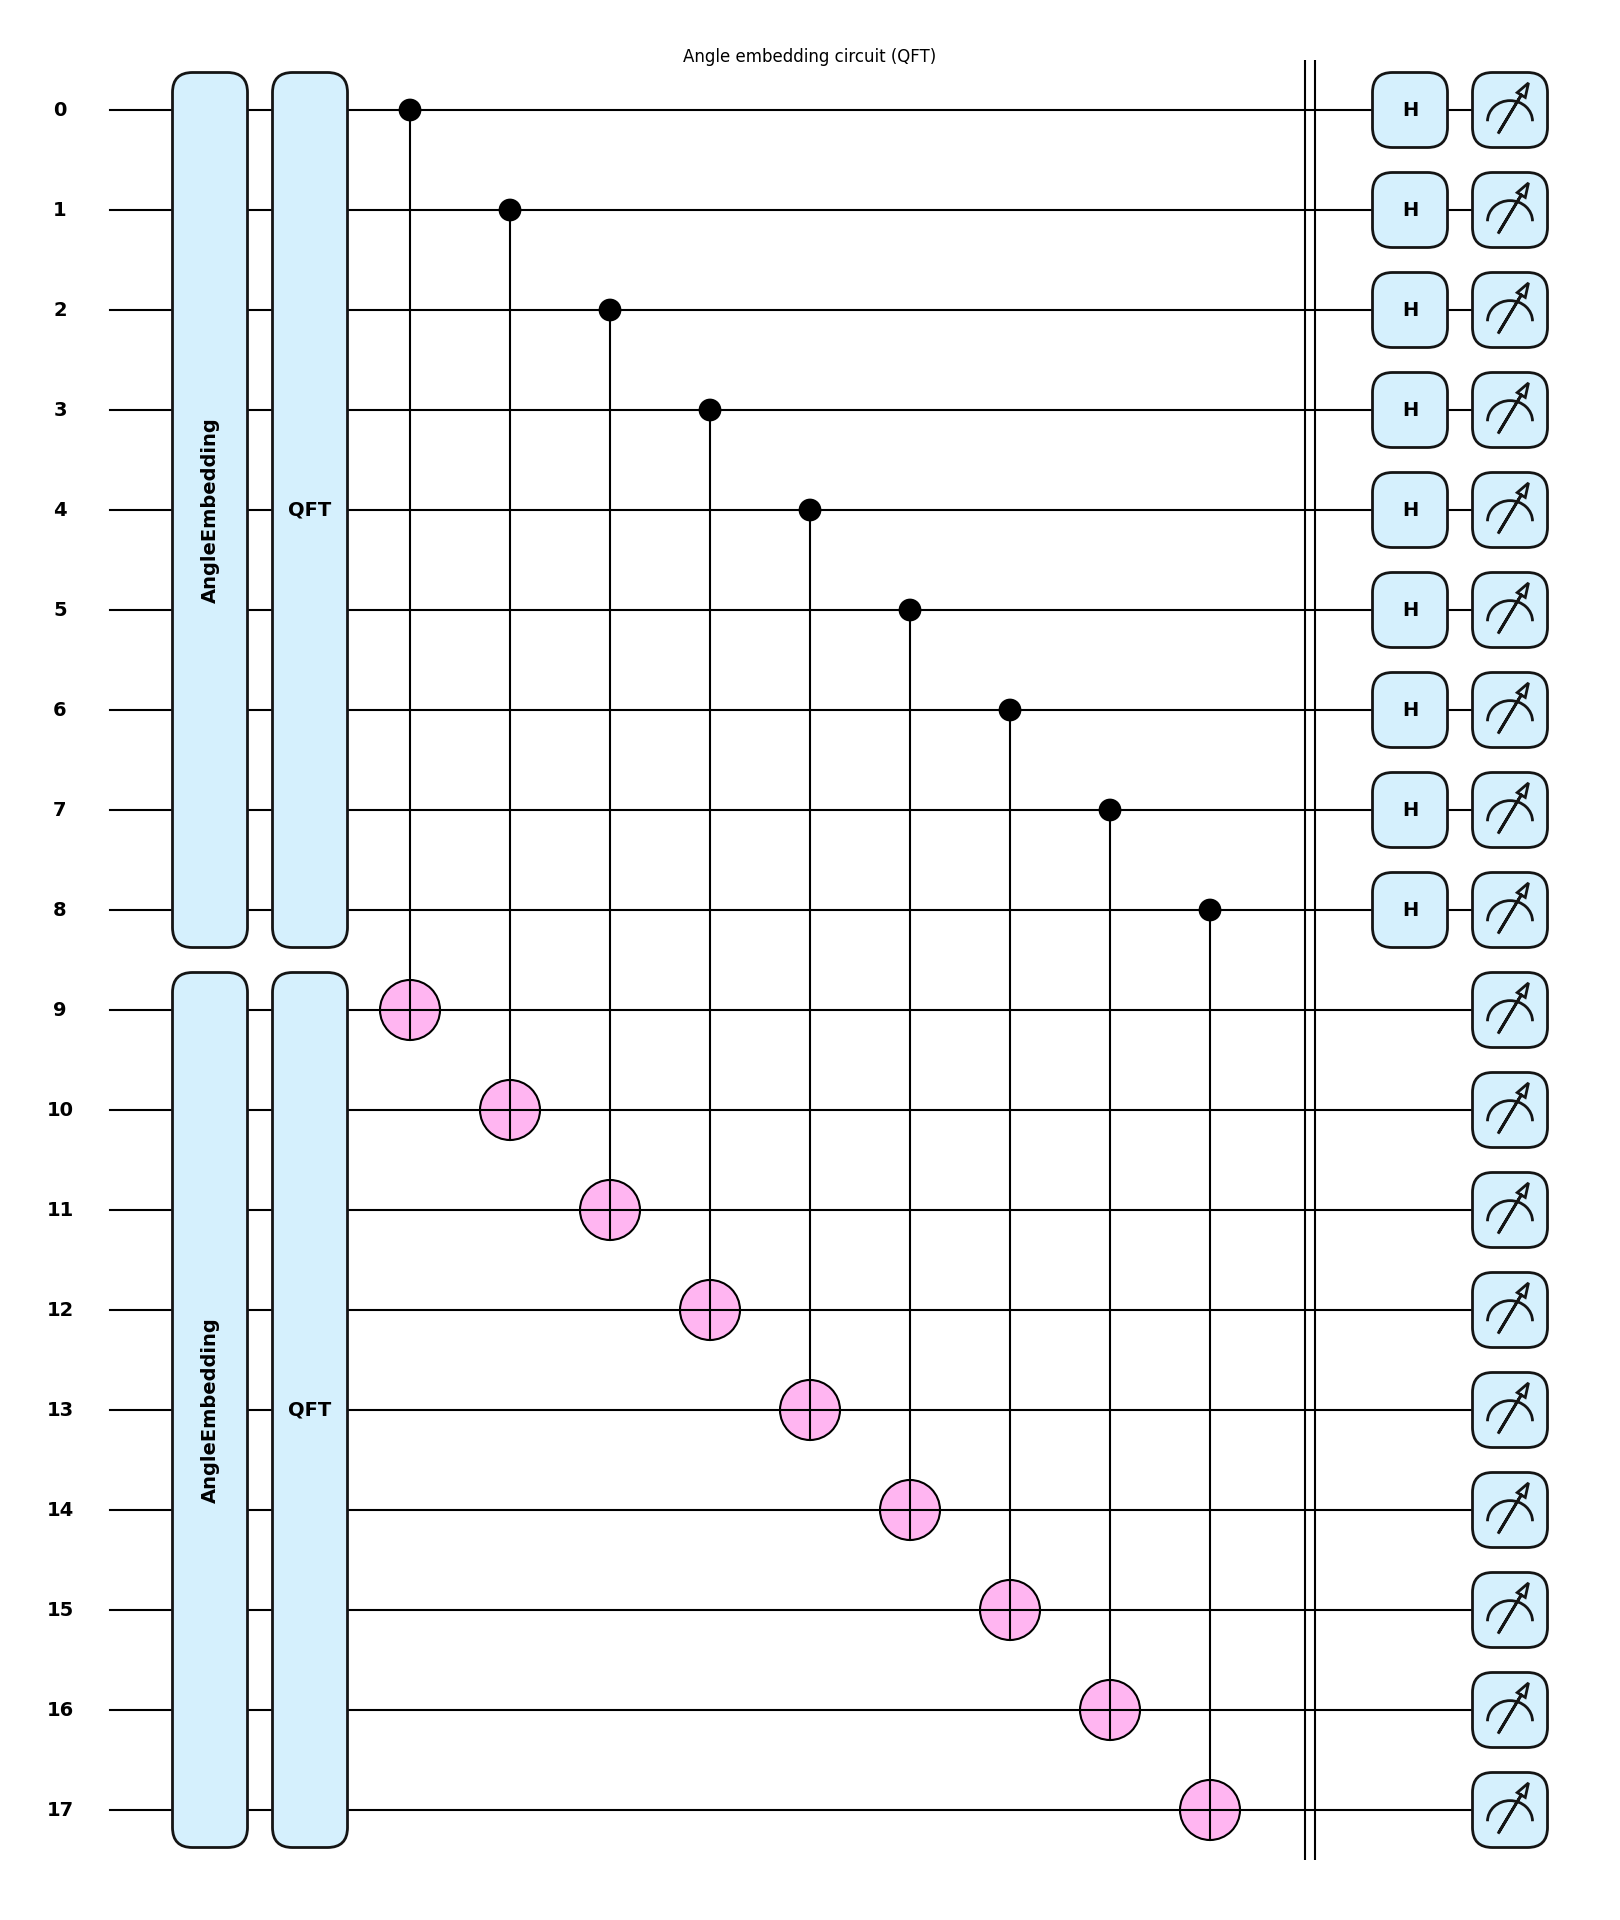

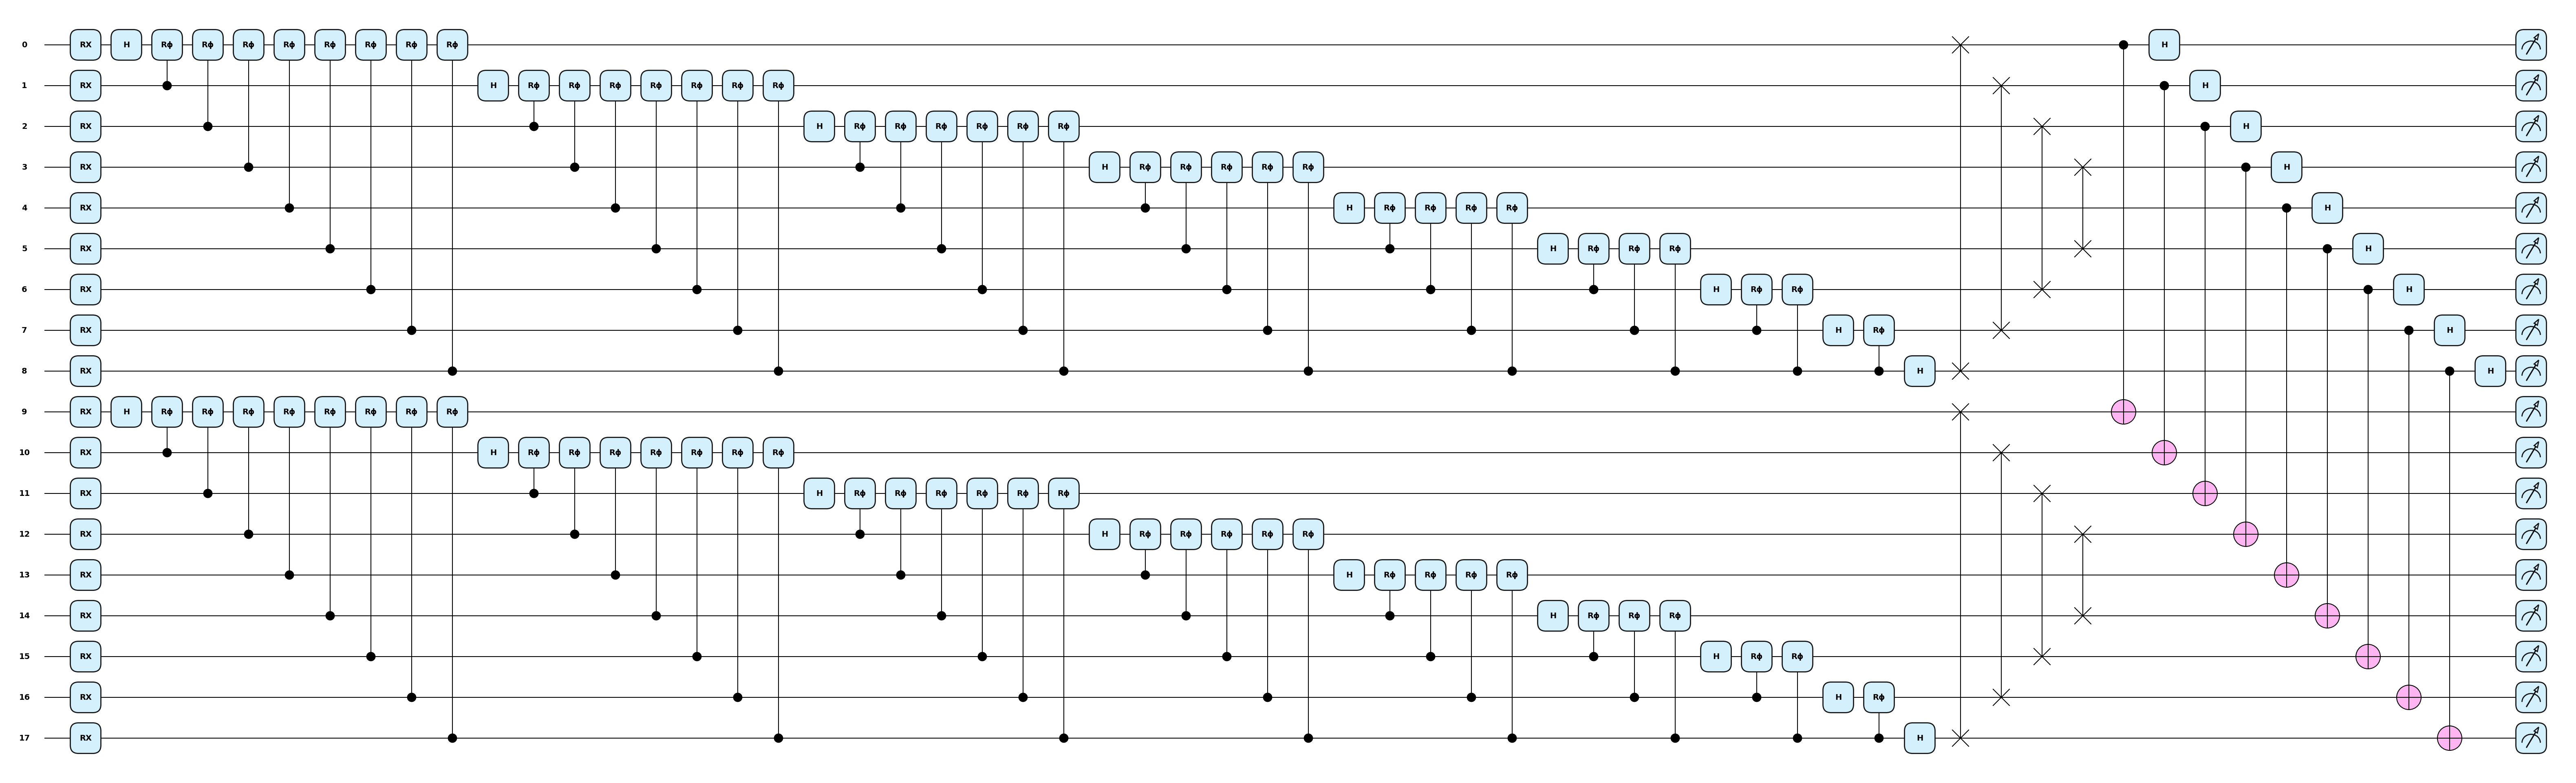

In [8]:
qml.draw_mpl(circuit_ang_qft, level='user', style='pennylane')(a, a)
plt.suptitle('Angle embedding circuit (QFT)')
qml.draw_mpl(circuit_ang_qft, level='device', style='pennylane')(a, a)

(<Figure size 11100x500 with 1 Axes>, <Axes: >)

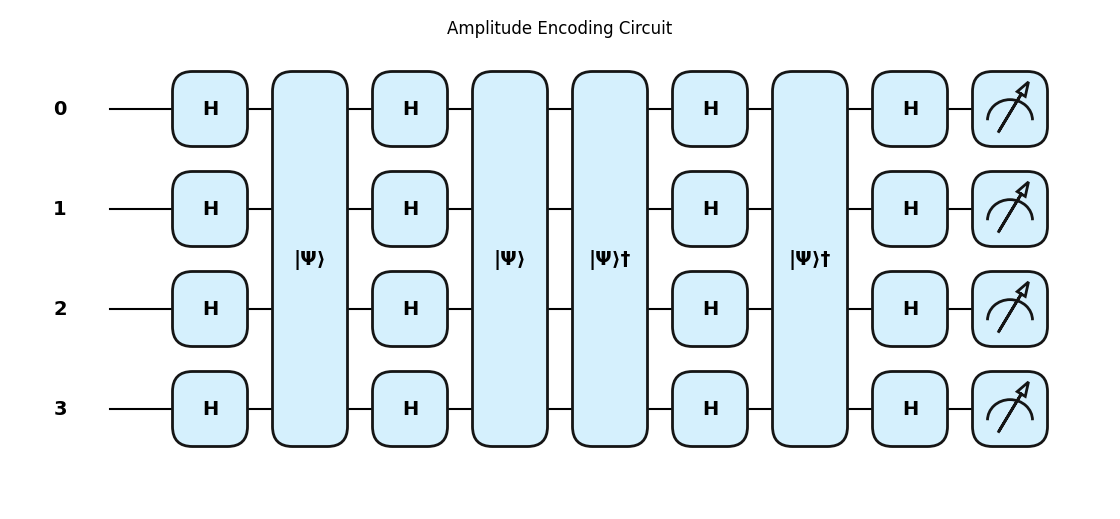

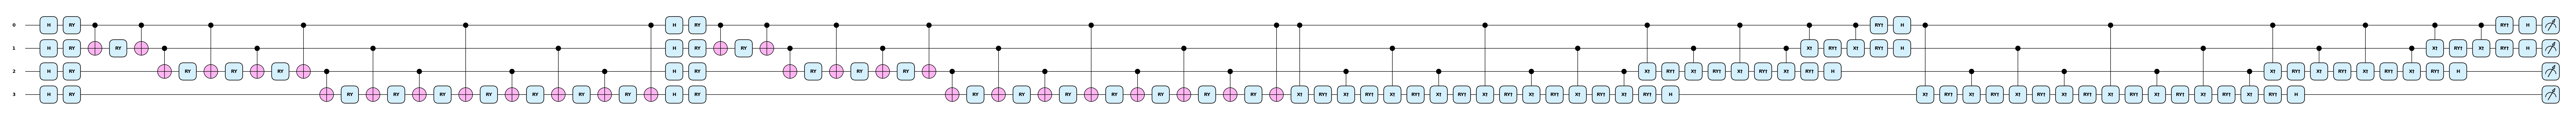

In [9]:
qml.draw_mpl(circuit_amp, level='user', style='pennylane')(b, b)
plt.suptitle('Amplitude Encoding Circuit')
qml.draw_mpl(circuit_amp, level='device', style='pennylane')(b, b)

(<Figure size 13500x500 with 1 Axes>, <Axes: >)

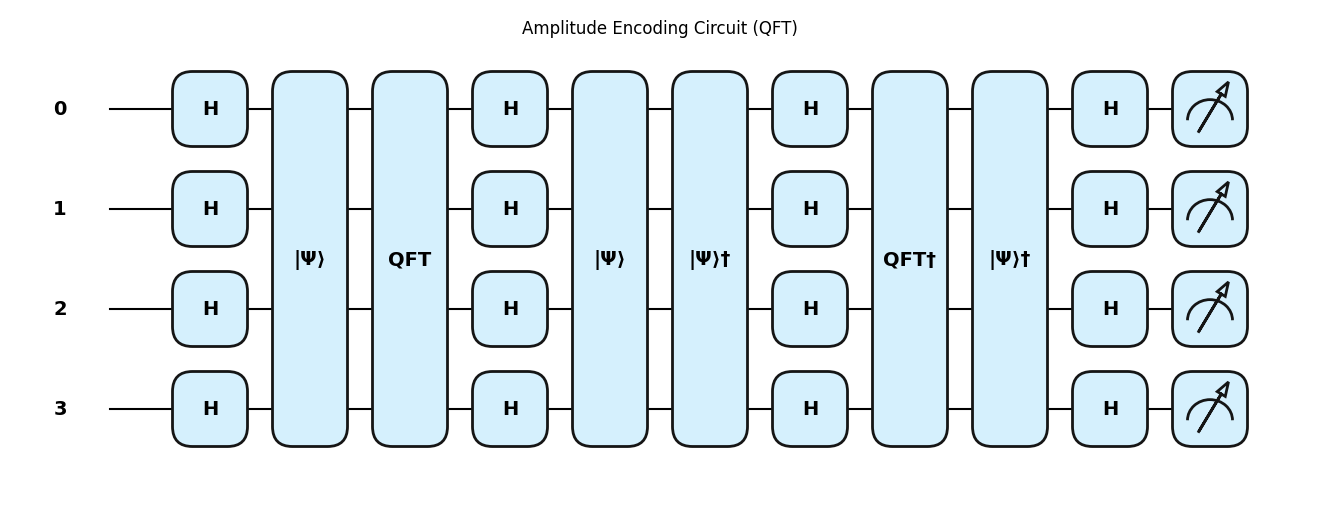

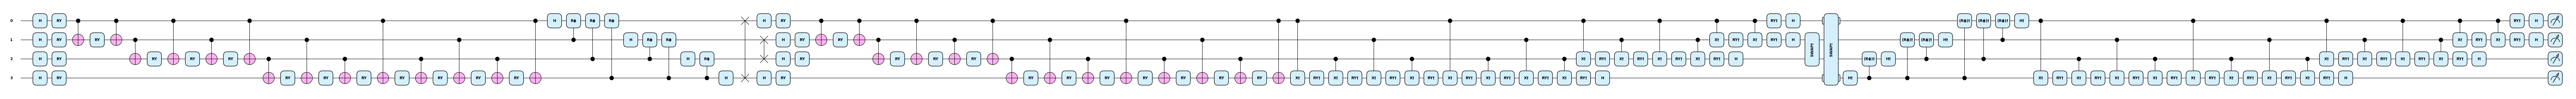

In [10]:
qml.draw_mpl(circuit_amp_qft, level='user', style='pennylane')(b, b)
plt.suptitle('Amplitude Encoding Circuit (QFT)')
qml.draw_mpl(circuit_amp_qft, level='device', style='pennylane')(b, b)

# Resource usage

In [11]:
qml.specs(circuit_ang.original_function, level='device')(a, a)['resources']

num_wires: 18
num_gates: 36
depth: 3
shots: Shots(total=None)
gate_types:
{'RX': 18, 'CNOT': 9, 'Hadamard': 9}
gate_sizes:
{1: 27, 2: 9}


In [12]:
qml.specs(circuit_ang_qft.original_function, level='device')(a, a)['resources']

num_wires: 18
num_gates: 134
depth: 21
shots: Shots(total=None)
gate_types:
{'RX': 18, 'Hadamard': 27, 'ControlledPhaseShift': 72, 'SWAP': 8, 'CNOT': 9}
gate_sizes:
{1: 45, 2: 89}


In [13]:
qml.specs(circuit_amp.original_function, level='device')(b, b)['resources']

num_wires: 4
num_gates: 132
depth: 108
shots: Shots(total=None)
gate_types:
{'Hadamard': 16, 'RY': 30, 'CNOT': 28, 'Adjoint(CNOT)': 28, 'Adjoint(RY)': 30}
gate_sizes:
{1: 76, 2: 56}


In [14]:
qml.specs(circuit_amp_qft.original_function, level='device')(b, b)['resources']

num_wires: 4
num_gates: 156
depth: 124
shots: Shots(total=None)
gate_types:
{'Hadamard': 20, 'RY': 30, 'CNOT': 28, 'ControlledPhaseShift': 6, 'SWAP': 2, 'Adjoint(CNOT)': 28, 'Adjoint(RY)': 30, 'Adjoint(SWAP)': 2, 'Adjoint(Hadamard)': 4, 'Adjoint(ControlledPhaseShift)': 6}
gate_sizes:
{1: 84, 2: 72}


# data loading

record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons].apply(lambda x: rescale(x, np.pi/2), axis=1)
coords = get_coords(record).loc[sig_neurons]

In [15]:
rescaled_tuning_curves = pd.read_csv(ENV['PWD'] + '/data/rescaled_tuning_curves.csv', index_col=0)
rescaled_tuning_curves

,3.0,4.2,6.0,8.5,12.0,17.0,24.0,33.9,48.0
23,0.272445,0.226280,0.528095,0.342139,0.478668,0.216327,0.388480,0.282726,0.406432
32,0.246955,0.251824,0.261320,0.301364,0.240421,0.677847,0.152107,0.650394,0.359361
35,0.329700,0.345059,0.396044,0.403043,0.472854,0.287826,0.304725,0.239381,0.362960
36,0.293999,0.259318,0.282788,0.360842,0.323867,0.329879,0.353300,0.333539,0.604061
37,0.239892,0.220883,0.447163,0.443715,0.374524,0.325597,0.328626,0.408209,0.352983
...,...,...,...,...,...,...,...,...,...
424,0.211562,0.142474,0.785516,0.386134,0.361296,0.342168,0.184937,0.168489,0.559018
425,0.306663,0.238587,0.426167,0.401231,0.506186,0.294095,0.299420,0.296495,0.372749
426,0.314137,0.290121,0.517580,0.374248,0.256840,0.341100,0.333903,0.349291,0.364372
428,0.307663,0.282272,0.377610,0.382645,0.434304,0.299115,0.426110,0.349712,0.282161


In [16]:
resampled_tuning_curves = pd.read_csv(ENV['PWD'] + '/data/resampled_tuning_curves.csv', index_col=0)
resampled_tuning_curves

,3.0,3.6,4.3,5.2,6.3,7.6,9.1,10.9,13.2,15.8,19.0,22.9,27.6,33.2,39.9,48.0
23,0.049073,0.039918,0.042466,0.075074,0.094048,0.071611,0.064602,0.082698,0.077755,0.044527,0.046081,0.068616,0.063313,0.051262,0.055749,0.073207
32,0.043356,0.043741,0.044285,0.045031,0.046348,0.050228,0.052905,0.044969,0.052667,0.108142,0.099962,0.031631,0.052624,0.111210,0.109811,0.063090
35,0.059220,0.060157,0.062332,0.067351,0.071698,0.071929,0.074087,0.082499,0.080567,0.056549,0.052081,0.055091,0.050466,0.043463,0.047315,0.065194
36,0.054015,0.049772,0.047671,0.049213,0.053367,0.062580,0.065870,0.061018,0.059588,0.060128,0.061826,0.064329,0.064520,0.061341,0.073780,0.110982
37,0.042642,0.037452,0.040609,0.064365,0.080144,0.080781,0.076793,0.069766,0.063875,0.058910,0.057124,0.057708,0.063151,0.071911,0.072028,0.062744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.038788,0.022251,0.029875,0.101378,0.141131,0.094036,0.069800,0.067258,0.065521,0.064002,0.056276,0.037474,0.028246,0.029893,0.051580,0.102491
425,0.055056,0.044896,0.043907,0.063648,0.076840,0.072887,0.074830,0.087617,0.085388,0.057789,0.053026,0.053720,0.053528,0.053216,0.056730,0.066920
426,0.056335,0.050662,0.053334,0.078388,0.091691,0.077286,0.062515,0.048800,0.048563,0.059304,0.060755,0.059765,0.060875,0.062461,0.063923,0.065344
428,0.054627,0.050518,0.050672,0.060430,0.067494,0.067470,0.069372,0.075302,0.074053,0.056338,0.058207,0.074734,0.071477,0.062910,0.056297,0.050099


In [17]:
def get_fidelity(data1:list[int], data2:list[int], circuit, postprocess) -> tuple[Float,Float]:
    # data1 should be less than data2
    if is_array_lesser(data2, data1):
        return get_fidelity(data2, data1, circuit, postprocess)

    probs = circuit(data1, data2)
    fidelity = postprocess(probs)
    return fidelity

def get_fidelities(datum, circuit, postprocess):
    quantum_fidelity = pd.DataFrame(columns = ['A', 'B', 'fidelity'])

    # A x B
    pairs, pairs_len = combinations(datum.index, 2), (len(datum) * (len(datum) - 1) // 2)
    for a, b in tqdm(pairs, total=pairs_len):
        a_i, b_i = datum.loc[a], datum.loc[b]
        fidelity = get_fidelity(a_i, b_i, circuit, postprocess)
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, b, fidelity]
        quantum_fidelity.loc[len(quantum_fidelity)] = [b, a, fidelity]

    # A x A
    # for sanity checking
    for a in tqdm(datum.index):
        a_i = datum.loc[a]
        fidelity = get_fidelity(a_i, a_i, circuit, postprocess)
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, a, fidelity]

    quantum_fidelity = quantum_fidelity.pivot_table(index = 'A', columns = 'B')['fidelity'].astype(np.float64)
    return quantum_fidelity


In [18]:
# fidelity defined as average of eigenvalues??
circuit_ang_results = get_fidelities(
    rescaled_tuning_curves,
    circuit_ang, lambda probs: swap_expectation(probs, len(rescaled_tuning_curves.columns))[1]
)

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [19]:
# fidelity defined as average of eigenvalues??
circuit_ang_qft_results = get_fidelities(
    rescaled_tuning_curves,
    circuit_ang_qft, lambda probs: swap_expectation(probs, len(rescaled_tuning_curves.columns))[1]
)

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [20]:
# fidelity defined as prob of 0 state
circuit_amp_results = get_fidelities(resampled_tuning_curves, circuit_amp, lambda probs: probs[0])

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [21]:
circuit_amp_qft_results = get_fidelities(resampled_tuning_curves, circuit_amp_qft, lambda probs: probs[0])

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [22]:
# Save the results for analysis
circuit_ang_results.to_csv(ENV['PWD'] + '/data/quantum_fidelity_angle_embed.csv')
circuit_ang_qft_results.to_csv(ENV['PWD'] + '/data/quantum_fidelity_angle_embed_qft.csv')
circuit_amp_results.to_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed.csv')
circuit_amp_qft_results.to_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_embed_qft.csv')